In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob

In [2]:
player_plays = pl.read_csv("data/player_play.csv", null_values=["NA"])
games = pl.read_csv("data/games.csv", null_values=["NA"])
plays = pl.read_csv("data/plays.csv", null_values=["NA"])
players = pl.read_csv("data/players.csv", null_values=["NA"])

In [3]:
tracking_files = glob.glob("data/tracking_week_*.csv")
tracking_data = pl.concat([pl.read_csv(f, null_values= ["NA"]) for f in tracking_files])

In [4]:
tracking_data

gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
i64,i64,i64,str,i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str
2022101000,57,41265,"""Derek Carr""",1,"""BEFORE_SNAP""","""2022-10-11 00:15:50.4""",4,"""LV""","""right""",30.79,27.19,0.01,0.02,0.05,160.57,89.24,"""huddle_break_offense"""
2022101000,57,41265,"""Derek Carr""",2,"""BEFORE_SNAP""","""2022-10-11 00:15:50.5""",4,"""LV""","""right""",30.82,27.18,0.06,1.12,0.03,139.97,108.86,null
2022101000,57,41265,"""Derek Carr""",3,"""BEFORE_SNAP""","""2022-10-11 00:15:50.6""",4,"""LV""","""right""",30.83,27.18,0.28,2.37,0.02,130.14,112.37,null
2022101000,57,41265,"""Derek Carr""",4,"""BEFORE_SNAP""","""2022-10-11 00:15:50.7""",4,"""LV""","""right""",30.88,27.16,0.61,3.0,0.05,127.5,110.94,null
2022101000,57,41265,"""Derek Carr""",5,"""BEFORE_SNAP""","""2022-10-11 00:15:50.8""",4,"""LV""","""right""",30.96,27.14,0.99,3.37,0.09,124.22,109.28,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022102700,4356,null,"""football""",73,"""AFTER_SNAP""","""2022-10-28 03:22:38.3""",null,"""football""","""right""",63.959999,23.969999,0.0,0.0,0.0,null,null,"""qb_kneel"""
2022102700,4356,null,"""football""",74,"""AFTER_SNAP""","""2022-10-28 03:22:38.4""",null,"""football""","""right""",63.959999,23.969999,0.0,0.0,0.0,null,null,null
2022102700,4356,null,"""football""",75,"""AFTER_SNAP""","""2022-10-28 03:22:38.5""",null,"""football""","""right""",63.959999,23.969999,0.0,0.0,0.0,null,null,null


In [5]:
# Rename columns in `tracking_data`
tracking_data = tracking_data.rename({"s":"yardsPerSecond", "a":"acceleration","o":"orientation"})

In [6]:
tracking_data['event'].unique().to_list()

['touchdown',
 'pass_tipped',
 'dropped_pass',
 'first_contact',
 'penalty_accepted',
 'qb_spike',
 'man_in_motion',
 'qb_sack',
 'pass_outcome_incomplete',
 'shift',
 'run',
 'autoevent_passinterrupted',
 None,
 'pass_outcome_touchdown',
 'huddle_start_offense',
 'out_of_bounds',
 'fumble',
 'huddle_break_offense',
 'tackle',
 'handoff',
 'pass_shovel',
 'pass_arrived',
 'qb_kneel',
 'run_pass_option',
 'autoevent_passforward',
 'safety',
 'field_goal_play',
 'play_submit',
 'play_action',
 'timeout_away',
 'fumble_offense_recovered',
 'pass_forward',
 'touchback',
 'fumble_defense_recovered',
 'snap_direct',
 'autoevent_ballsnap',
 'qb_strip_sack',
 'ball_snap',
 'pass_outcome_interception',
 'line_set',
 'penalty_flag',
 'qb_slide',
 'lateral',
 'pass_outcome_caught']

In [7]:
def calculate_presnap_movement(presnap:pl.DataFrame, snap:pl.DataFrame) -> pl.DataFrame:
    merged = presnap.join(snap, on='displayName', suffix='_snap')
    merged = merged.with_columns(
     (pl.col("x")-pl.col("x_snap")).alias("x_dif"),
     (pl.col("y")-pl.col("y_snap")).alias("y_dif")
    ).sort((pl.col("y_dif")))
    return merged

def determine_sides(game_df:pl.DataFrame, players_df:pl.DataFrame) -> pl.DataFrame:
    offensive_positions = {"QB", "RB", "T", "FB", "G", "C", "WR", "TE"}
    game_with_positions = game_df.join(players_df.select(["displayName", "position"]), on="displayName")
    game_with_sides = game_with_positions.with_columns(
        (pl.col("position").is_in(offensive_positions)).alias("isOffense")
    )
    return game_with_sides

def get_play_outcome(gameId:int, playId:int, plays: pl.DataFrame) -> pl.DataFrame:
    ret = plays.filter(
        (pl.col("gameId")==gameId) &
        (pl.col("playId")==playId)
    )

    return ret

def analyze_man_in_motion(game_df:pl.DataFrame, players_df:pl.DataFrame, plays_df:pl.DataFrame) -> None:
    mim_game_df = game_df.filter(
        (pl.col("event") == "man_in_motion")
    )
    plays = mim_game_df.group_by("playId", maintain_order=True)
    for play_id, play_df in plays:
        pre = play_df.filter(
            (pl.col("frameType") == "BEFORE_SNAP")
        )
        snap = game_df.filter(
            (pl.col("frameType") == "SNAP") &
            (pl.col("playId") == play_id[0])
        )
        play_side_df = determine_sides(pre, players_df)
        play_df = calculate_presnap_movement(play_side_df, snap)
        try:
            off = play_df.filter(
                (pl.col("isOffense") == True)
            ).sort((pl.col("y_dif")), descending=True)
            player= off[0]['displayName'][0]
            dis = round(off[0]['y_dif'][0], 2)
            if dis < 1:
                continue
            dir = off[0]['playDirection'][0]
            pos = off[0]['position'][0]
            print(f"Processed playId: {play_id[0]}\nPresnap movement: {pos} {player} moved {dis} yards to the {dir}.")
            determine_play_outcome(game_df.filter((pl.col("playId")==play_id[0])), plays_df)
        except:
            continue

def analyze_presnap_play(game_df:pl.DataFrame, players_df:pl.DataFrame, plays_df:pl.DataFrame)->None:
    gameId = game_df["gameId"][0]
    game_as_plays = game_df.group_by("playId", maintain_order=True)
    plays_df = plays_df.filter((pl.col("gameId")==gameId))
    play_dict = {}
    for play_id, play_df in game_as_plays:
        b = {"Presnap Movement":False, "Outcome":None,"Quarter":None, "Coverage":None}
        if "man_in_motion" in play_df["event"].unique():
            b["Presnap Movement"] = True
        outcome = get_play_outcome(gameId, play_id[0], plays_df)
        b["Quarter"] = outcome['quarter'][0]
        b["Outcome"] = outcome['playDescription'][0]
        b["Coverage"] = outcome['pff_manZone'][0]
        play_dict[play_id]=b
    
    p = 1
    for k, v in play_dict.items():
        print(f"Play {p}(#{k[0]}):")
        print(f"Presnap:{'movement' if v['Presnap Movement'] else 'no movement.'}")
        print(f"{v['Outcome'][:-1]} facing {v['Coverage'].lower() if v['Coverage'] != None else 'no'} coverage.\n")
        p+=1


def determine_play_outcome(play_df:pl.DataFrame, plays:pl.DataFrame) -> pl.DataFrame:
    # this needs to be verified.
    pre_snap_pos = play_df.filter(
        (pl.col("frameType") == "BEFORE_SNAP") &
        (pl.col("displayName") == "football") &
        (pl.col("event") != "None") 
    )
    post_snap_pos = play_df.filter(
        (pl.col("frameType") == "AFTER_SNAP") &
        (pl.col("displayName") == "football") &
        (pl.col("event") != "None") 
    )
    pre_coord = [pre_snap_pos["x"][0], pre_snap_pos["y"][0]]
    post_coord = [post_snap_pos["x"][0], post_snap_pos["y"][0]]
    if pre_coord == post_coord:
        print("No change in position.")
        return 0
    else:
        print(f"Ball moved from the {round(pre_coord[0])} yard line to the {round(post_coord[0])} yard line for a gain of {round(abs(post_coord[0]-pre_coord[0]), 1)}.")
        r = get_play_outcome(playId=post_snap_pos["playId"][0], gameId=post_snap_pos["gameId"][0], plays=plays)
        print(f"{r['playDescription'][0]}\n")
        return 

def build_field(ax:plt.Axes):
    # Draw field background
    ax.set_facecolor('green')
    ax.set_xlim(0, 120)   # NFL field length including end zones
    ax.set_ylim(0, 53.3)  # NFL field width

    # Add end zones
    ax.add_patch(patches.Rectangle((0, 0), 10, 53.3, linewidth=0, color='gray'))      # Home endzone
    ax.add_patch(patches.Rectangle((110, 0), 10, 53.3, linewidth=0, color='gray'))    # Visitor endzone

    # Add yard lines
    for x in range(10, 111, 10):
        ax.plot([x, x], [0, 53.3], color='white', linewidth=1.5)
        if x < 60:
            ax.text(x, 55, f'{x//10}', ha='center', color='white', fontsize=10)
            ax.text(x, -2, f'{x//10}', ha='center', color='white', fontsize=10)
        elif x > 60:
            ax.text(x, 55, f'{12 - x//10}', ha='center', color='white', fontsize=10)
            ax.text(x, -2, f'{12 - x//10}', ha='center', color='white', fontsize=10)

    # Plot sidelines
    ax.plot([0, 120], [0, 0], color='white', linewidth=2)
    ax.plot([0, 120], [53.3, 53.3], color='white', linewidth=2)
    
    # Set labels and title
    ax.set_xlabel('Field Length (Yards)')
    ax.set_ylabel('Field Width (Yards)')
    ax.set_title(f'Player Positions Pre Snap')


def show_play_presnap_scheme(play_id:int, play_df:pl.DataFrame, players:pl.DataFrame,) -> None:
    init_timestamp = play_df.filter((pl.col("playId")==play_id) &
        (pl.col("frameType")=="BEFORE_SNAP") &
        (pl.col("event") == "line_set"))
    plot_df = determine_sides(play_df, players).filter(
        (pl.col("playId")==play_id) &
        (pl.col("frameType")=="BEFORE_SNAP") &
        (pl.col("event") != "null") &
        (pl.col("time") == init_timestamp["time"][0])
    )
    ball_pos = play_df.filter(
        (pl.col("time")== init_timestamp["time"][0]) & 
        (pl.col("displayName") =="football")
    )[0]
    ball_coors = [ball_pos["x"].to_numpy()[0],ball_pos["y"].to_numpy()[0]]
    off_x_coords = plot_df.filter((pl.col("isOffense")== True))['x'].to_numpy()
    off_y_coords = plot_df.filter((pl.col("isOffense") == True))['y'].to_numpy()
    def_x_coords = plot_df.filter((pl.col("isOffense") == False))['x'].to_numpy()
    def_y_coords = plot_df.filter((pl.col("isOffense") == False))['y'].to_numpy()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6.33))

    build_field(ax)

    # Plot x and y coordinates
    ax.scatter(off_x_coords, off_y_coords, color="red", s=50, alpha=0.7, label="Offense")
    ax.scatter(def_x_coords, def_y_coords, color="blue", s=50, alpha=0.7, label="Defense")
    ax.scatter(ball_coors[0], ball_coors[-1], color="black", s=50, alpha=0.7, label="Ball", marker='X')
    ax.legend(loc='upper right')
    plt.show()


def show_play_aftersnap_scheme(play_id:int, play_df:pl.DataFrame, players:pl.DataFrame,) -> None:
    plot_df = determine_sides(play_df, players).filter(
        (pl.col("playId")==play_id) &
        (pl.col("frameType")=="AFTER_SNAP") &
        (pl.col("event") != "null")
    )

    plot_df=plot_df.filter(
        (pl.col("time") == plot_df["time"][-1])
    )
    ball_pos = play_df.filter(
        (pl.col("time")== plot_df["time"][-1]) & 
        (pl.col("displayName") =="football")
    )[0]
    ball_coors = [ball_pos["x"].to_numpy()[0],ball_pos["y"].to_numpy()[0]]
    off_x_coords = plot_df.filter((pl.col("isOffense")== True))['x'].to_numpy()
    off_y_coords = plot_df.filter((pl.col("isOffense") == True))['y'].to_numpy()
    def_x_coords = plot_df.filter((pl.col("isOffense") == False))['x'].to_numpy()
    def_y_coords = plot_df.filter((pl.col("isOffense") == False))['y'].to_numpy()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6.33))
    build_field(ax)
    

    # Plot x and y coordinates
    ax.scatter(off_x_coords, off_y_coords, color="red", s=50, alpha=0.7, label="Offense")
    ax.scatter(def_x_coords, def_y_coords, color="blue", s=50, alpha=0.7, label="Defense")
    ax.scatter(ball_coors[0], ball_coors[-1], color="black", s=50, alpha=0.7, label="Ball", marker='X')
    ax.legend(loc='upper right')
    plt.show()



In [8]:
gameIdArr = tracking_data["gameId"].unique()

In [9]:
test_game = tracking_data.filter(
    (pl.col("gameId") == 2022102700)
)

In [10]:
test_game

gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,yardsPerSecond,acceleration,dis,orientation,dir,event
i64,i64,i64,str,i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str
2022102700,68,38557,"""Kevin Zeitler""",1,"""BEFORE_SNAP""","""2022-10-28 00:16:19.3""",70,"""BAL""","""right""",29.6,28.89,0.3,1.48,0.02,96.19,204.7,"""huddle_break_offense"""
2022102700,68,38557,"""Kevin Zeitler""",2,"""BEFORE_SNAP""","""2022-10-28 00:16:19.4""",70,"""BAL""","""right""",29.57,28.87,0.37,1.1,0.03,96.19,228.32,null
2022102700,68,38557,"""Kevin Zeitler""",3,"""BEFORE_SNAP""","""2022-10-28 00:16:19.5""",70,"""BAL""","""right""",29.54,28.87,0.39,0.77,0.03,96.19,247.1,null
2022102700,68,38557,"""Kevin Zeitler""",4,"""BEFORE_SNAP""","""2022-10-28 00:16:19.6""",70,"""BAL""","""right""",29.5,28.86,0.42,0.53,0.04,96.19,256.38,null
2022102700,68,38557,"""Kevin Zeitler""",5,"""BEFORE_SNAP""","""2022-10-28 00:16:19.7""",70,"""BAL""","""right""",29.47,28.87,0.41,0.53,0.04,97.63,273.58,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022102700,4356,null,"""football""",73,"""AFTER_SNAP""","""2022-10-28 03:22:38.3""",null,"""football""","""right""",63.959999,23.969999,0.0,0.0,0.0,null,null,"""qb_kneel"""
2022102700,4356,null,"""football""",74,"""AFTER_SNAP""","""2022-10-28 03:22:38.4""",null,"""football""","""right""",63.959999,23.969999,0.0,0.0,0.0,null,null,null
2022102700,4356,null,"""football""",75,"""AFTER_SNAP""","""2022-10-28 03:22:38.5""",null,"""football""","""right""",63.959999,23.969999,0.0,0.0,0.0,null,null,null


In [11]:
analyze_man_in_motion(test_game, players, plays)

Processed playId: 97
Presnap movement: WR James Proche moved 8.34 yards to the right.
Ball moved from the 53 yard line to the 46 yard line for a gain of 6.5.
(14:18) (Shotgun) L.Jackson pass short right to M.Andrews to BLT 48 for 5 yards (K.Neal; S.Barrett).

Processed playId: 222
Presnap movement: WR Devin Duvernay moved 2.23 yards to the right.
Ball moved from the 100 yard line to the 93 yard line for a gain of 6.8.
(11:54) (Shotgun) L.Jackson pass short left to J.Proche to TB 4 for 6 yards (M.Edwards).

Processed playId: 246
Presnap movement: WR Devin Duvernay moved 15.56 yards to the right.
Ball moved from the 105 yard line to the 97 yard line for a gain of 7.9.
(11:09) (Shotgun) L.Jackson pass incomplete short right to M.Andrews (Z.McCollum).

Processed playId: 366
Presnap movement: WR Chris Godwin moved 14.0 yards to the left.
Ball moved from the 71 yard line to the 79 yard line for a gain of 8.3.
(9:42) (Shotgun) T.Brady pass short right to K.Kieft to TB 48 for 9 yards (D.Kennar

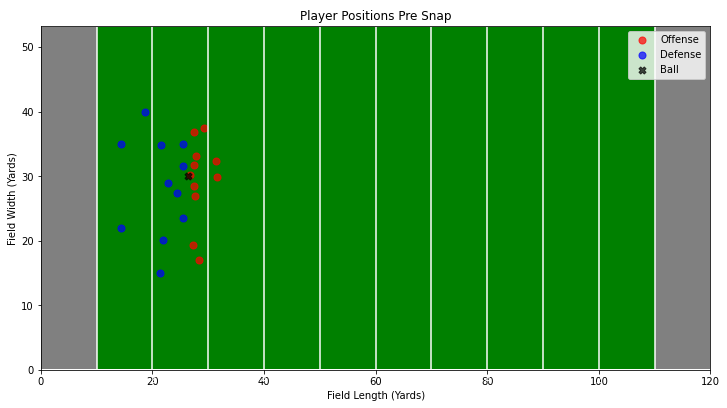

In [14]:
show_play_presnap_scheme(3671, test_game, players)

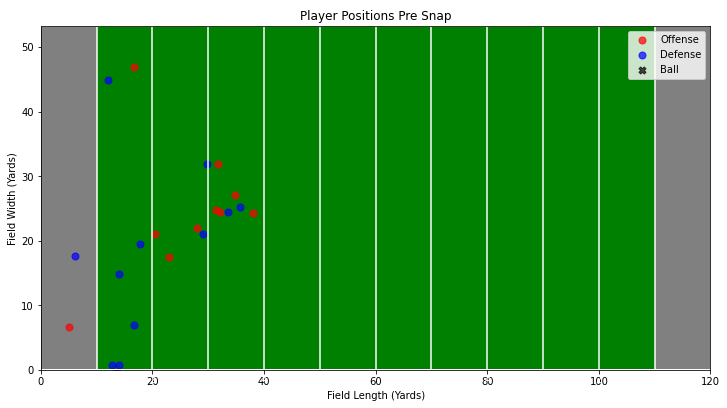

In [15]:
show_play_aftersnap_scheme(3671, test_game, players)

In [16]:
analyze_presnap_play(test_game, players, plays)

Play 1(#68):
Presnap:no movement.
(14:54) (Shotgun) L.Jackson pass short left to M.Andrews pushed ob at BLT 43 for 22 yards (K.Neal; M.Edwards) facing man coverage.

Play 2(#97):
Presnap:movement
(14:18) (Shotgun) L.Jackson pass short right to M.Andrews to BLT 48 for 5 yards (K.Neal; S.Barrett) facing zone coverage.

Play 3(#121):
Presnap:movement
(13:36) (Shotgun) L.Jackson pass short right to K.Drake pushed ob at BLT 44 for -4 yards (D.White) facing zone coverage.

Play 4(#150):
Presnap:no movement.
(12:52) (Shotgun) L.Jackson pass incomplete short middle to M.Andrews (L.David) facing zone coverage.

Play 5(#201):
Presnap:no movement.
(12:37) (Shotgun) L.Jackson up the middle to TB 10 for -4 yards (S.Barrett) facing man coverage.

Play 6(#222):
Presnap:movement
(11:54) (Shotgun) L.Jackson pass short left to J.Proche to TB 4 for 6 yards (M.Edwards) facing other coverage.

Play 7(#246):
Presnap:movement
(11:09) (Shotgun) L.Jackson pass incomplete short right to M.Andrews (Z.McCollum) f